# IAPR: Final project 

**Group ID:** 42

**Author 1 (sciper):** Orélian Kohler (312533)  
**Author 2 (sciper):** Quang Long Ho Ngo (310781)  
**Author 3 (sciper):** Caroline Legrand (303057)

In [41]:
# Imports for the project
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.tensorboard import SummaryWriter # For Tensorboard
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import dlib
import cv2
import json
from IPython.display import clear_output
import pandas as pd
import time
import random
import xml.etree.ElementTree as ET
import numpy as np
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import glob
import shutil
SEED = 0

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
POSSIBLE_VALUES = [
    "5CHF", "2CHF", "1CHF", "0.5CHF", "0.2CHF", "0.1CHF", "0.05CHF",
    "2EUR", "1EUR", "0.5EUR", "0.2EUR", "0.1EUR", "0.05EUR", "0.02EUR", "0.01EUR",
    "OOD"
    ]
COINS_DETECTOR_MODEL_PATH = r"coins-detector-model/coins-detector.svm"
COINS_IMAGES_FOLDER = r'./coins-images/'
COINS_ANNOTATIONS_FILE = r'coins-annotations.json'
TRAIN_FOLDER = r'./data/train'
IMAGES_BOUNDING_BOXES = r'./images-bounding-boxes/'
TEST_FOLDER = r'./data/test/'
CLASSIFIER_MODEL_PATH = r'./model/model.pth'
RESULT_FILE = r'./result/test-predictions.csv'

# Image segmentation with DLIB

## Explanation of the method

In order to detect the coins in the image, we have decided to use a library called Dlib that offers many tools for object detection.
The principle behind the detection is the use of an HOG (Histogram-of-Oriented-Gradient) and SVM (Support Vector Machine) detector.\

A brief explanation of HOG is explained below and the process of segmentation and classification with SVM.

### HOG (Histogram-of-Oriented-Gradient)
The Histogram of Oriented Gradients (HOG) is a common feature descriptor technique in computer vision and image processing. 
It analyzes the distribution of edge orientations within an object to describe its shape and appearance. The HOG method involves computing the gradient magnitude and orientation for each pixel in an image and then dividing the image into small cells.

Below is a sketch of the process used in HOG method:

<div style="text-align: center;">
<img src="images-report/SketchHOG.png" alt="Subdirectory Image" width="600" height="250">
</div>

Here is the HOG of a coin:

<div style="text-align: center;">
<img src="images-report/HOG.png" alt="Subdirectory Image">
</div>


### Training of the detector
The training of the detector involves several steps descrisbed below:

**Data Preparation**\
Gather labeled datasets containing images with annotated bounding boxes around objects of interest.

**Feature Extraction**\
Extract relevant features from the images, such as Histogram of Oriented Gradients (HOG), which capture important patterns and structures.

**Model Training**\
Utilize the extracted features to train a Support Vector Machine (SVM) classifier.
The SVM learns to distinguish between object and non-object regions in the images.
During training, the SVM adjusts its parameters to minimize classification errors and maximize detection accuracy.

At the end of the training, we have a detector that can be used on test images.

Here is the sketch of the training process:

<div style="text-align: center;">
<img src="images-report/Sketchtraining.png" alt="Subdirectory Image" width="600" height="100">
</div>

### Testing
The detection process with test images can be decomposed in several steps:

**Image Pyramid Construction**\
Construct an image pyramid consisting of multiple scaled versions of the test image.

**Sliding Window Technique**\
Apply a sliding window technique to scan through each level of the image pyramid.
Move a fixed-size window across the image at each scale and position.

**Feature Extraction**\
Extract relevant features with HOG from each region covered by the sliding window.

**Classification**\
Classify each region using a trained SVM classifier.
Compute a score indicating the likelihood of an object being present in the region.

**Non-Maximum Suppression**\
Apply non-maximum suppression to remove overlapping detections and retain only the most confident detections.
Suppress weak detections that do not meet a certain threshold.

**Output**\
Generate bounding boxes around detected objects based on the retained detections.
Optionally, label the detected objects and display the results on the original test image.

Here is a sketch of the several steps involved in the detection:

<div style="text-align: center;">
<img src="images-report/Sketchtesting.png" alt="Subdirectory Image" width="600" height="75">
</div>


### Choice of this method

We have decided to use this technics because it offers many advantages comparing to others tools offered in OpenCV for example.
Indeed, only few training images are needed to have a performant detector and the training takes small amount of times.
The training model used is a structural SVM (Support Vector Machine) which enables it to train on all the sub-windows in every image.  This means you don't have to perform any complicated subsampling.

Before finding this technic, we tried several other approaches such as HSV, RGB threshold or Hough circle transform but these technics were too sensitiv to the background. Having 3 different backgrounds (simple, hand, noisy) become it hard to have a generalize tool. 


### References

https://learnopencv.com/training-a-custom-object-detector-with-dlib-making-gesture-controlled-applications/ \
https://github.com/davisking/dlib




## Code

Fill the `./images-bounding-boxes` with the corresponding images for later calculation.

In [44]:
train_pattern = os.path.join(TRAIN_FOLDER, '*/*.JPG')

bounding_pattern = os.path.join(IMAGES_BOUNDING_BOXES, '*.xml')

dict_images = {}

for f in glob.glob(bounding_pattern):
    filename = f.split('/')[-1].split(".")[0]
    tree = ET.parse(f)
    root = tree.getroot()
    image_file = root.find("filename").text.split("_")[0]
    dict_images[image_file] = filename
for f in glob.glob(train_pattern):
    filename = f.split('/')[-1].split(".")[0]
    if filename in dict_images:
        shutil.copy(f, os.path.join(IMAGES_BOUNDING_BOXES, dict_images[filename])+ ".jpg")
    else:
        continue
    

In [2]:
# In this dictionary our images and annotations will be stored.
data = {}
# directory = r"images-bounding-boxes"

# List of image files with the 'jpg' extension
image_files = [f for f in os.listdir(IMAGES_BOUNDING_BOXES) if f.lower().endswith('.jpg')]

# Custom sorting function to sort filenames based on their numeric values
def sort_by_numeric_value(filename):
    return int(os.path.splitext(filename)[0])

# Sort the image files based on their numeric values
image_files_sorted = sorted(image_files, key=sort_by_numeric_value)

image_indexes = [int(os.path.splitext(img_name)[0]) for img_name in image_files_sorted if img_name.split('.')[0].isdigit()]

# Function to extract bounding box coordinates from a single XML file
def extract_bounding_boxes_from_xml(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize an empty list to store bounding box coordinates
    bounding_boxes = []

    # Iterate over each object element
    for obj in root.findall('object'):
        # Extract the bounding box coordinates
        xmin = int(obj.find('bndbox').find('xmin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        ymax = int(obj.find('bndbox').find('ymax').text)

        # Append the bounding box coordinates to the list
        bounding_boxes.append([xmin, ymin, xmax, ymax])

    # Convert the list of bounding box coordinates to a NumPy array
    bounding_boxes_array = np.array(bounding_boxes)
    
    return bounding_boxes_array

# Initialize an empty list to store bounding box arrays for all XML files
bounding_boxes_all_files = []

for filename in sorted(os.listdir(IMAGES_BOUNDING_BOXES)):
    if filename.endswith('.xml'):
        xml_file_path = os.path.join(IMAGES_BOUNDING_BOXES, filename)
        bounding_boxes_array = extract_bounding_boxes_from_xml(xml_file_path)
        bounding_boxes_all_files.append(bounding_boxes_array)
# Open and read the content of the boxes.txt file
box_dict = bounding_boxes_all_files

# Loop over all indexes
for index in image_indexes:
    
    # Read the image in memmory and append it to the list
    img = cv2.imread(os.path.join(IMAGES_BOUNDING_BOXES, str(index) + '.jpg'))    
    
    # Read the associated bounding_box
    bounding_box = box_dict[index]
    
    dlib_box = []
    for box in bounding_box:
        # Convert the bounding box to dlib format
        x1, y1, x2, y2  = box
        dlib_box.append(dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2))
    
    # Store the image and the box together
    data[index] = (img, dlib_box)

In [3]:
# This is the percentage of data we will use to test
# The rest will be used for training
percent = 0.2

# Split the dataset into training and testing
train_dataset, test_dataset = train_test_split(data, test_size=percent, random_state=SEED)
train_images = [d[0] for d in train_dataset]
train_bounding_boxes = [d[1] for d in train_dataset]

test_images = [d[0] for d in test_dataset]
test_bounding_boxes = [d[1] for d in test_dataset]

The training of the svm model may take some time.
We've provided a pretrained version in the directory `coins-detector-model/coins-detector.svm` to facilitate testing.

In [ ]:
# Initialize object detector Options
options = dlib.simple_object_detector_training_options()

# I'm disabling the horizontal flipping, becauase it confuses the detector if you're training on few examples
# By doing this the detector will only detect left or right hand (whichever you trained on). 
options.add_left_right_image_flips = False

# Set the c parameter of SVM equal to 5
# A bigger C encourages the model to better fit the training data, it can lead to overfitting.
# So set an optimal C value via trail and error.
options.C = 5

# Note the start time before training.
st = time.time()

# You can start the training now
detector = dlib.train_simple_object_detector(train_images, train_bounding_boxes, options)
# Print the Total time taken to train the detector
print('Training Completed, Total Time taken: {:.2f} seconds'.format(time.time() - st))

# file_name = 'coin-detector-model/coin-detector.svm'
print("Saving the model to file: ", COINS_DETECTOR_MODEL_PATH)
detector.save(COINS_DETECTOR_MODEL_PATH)

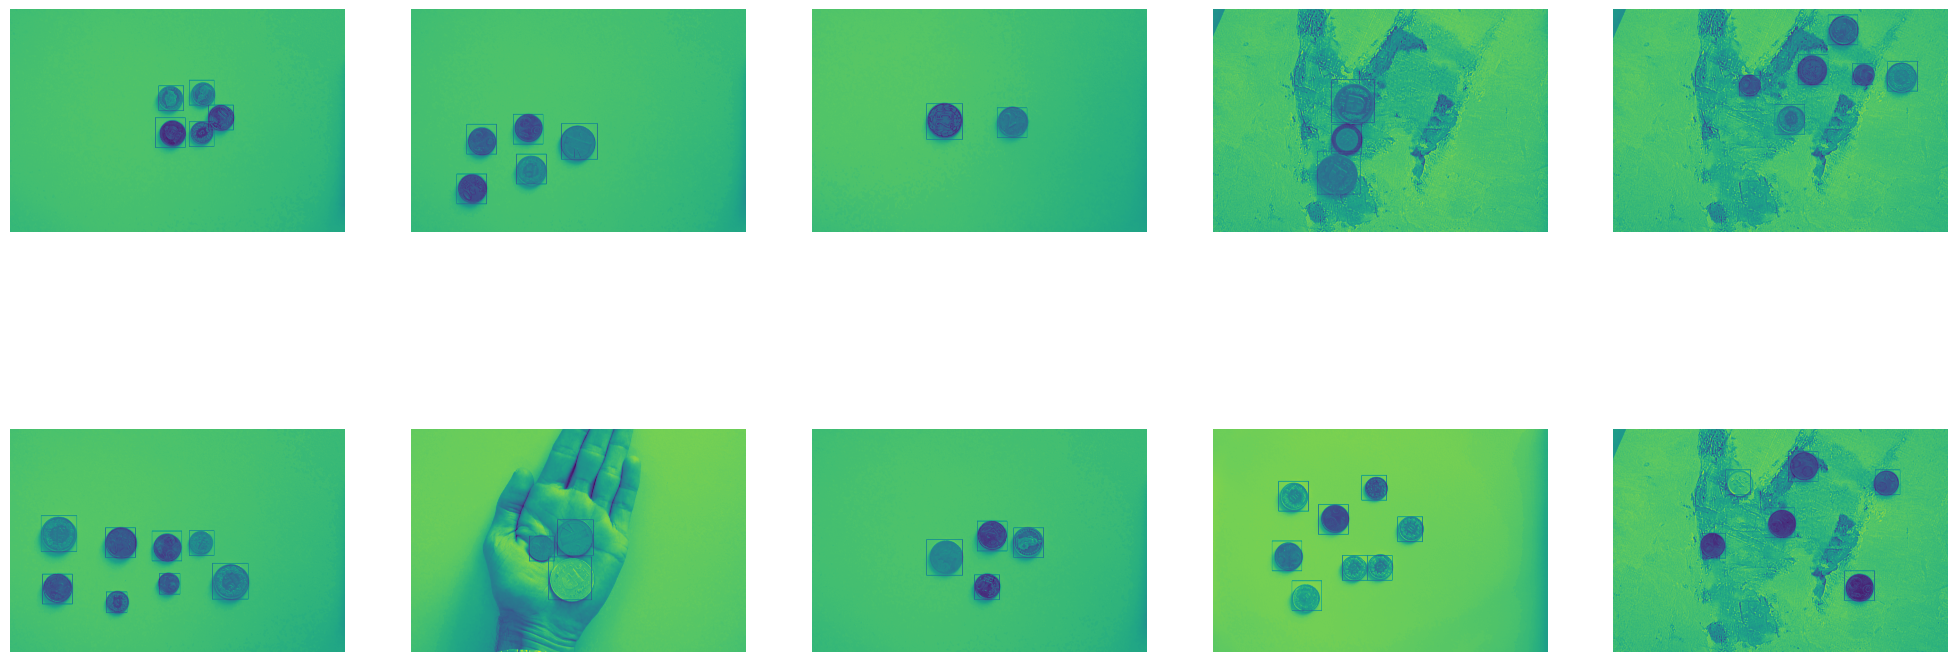

In [5]:
detector = dlib.simple_object_detector(COINS_DETECTOR_MODEL_PATH)
NUMBER_OF_SAMPLES = 10
test_sets = random.sample(test_images, NUMBER_OF_SAMPLES)
detector_test = []

for im in test_sets:
    detector_test.append(detector(im))

cols = 5

# Given the number of samples to display, what's the number of rows required.
rows = int(np.ceil(len(test_sets) / cols))

# Set the figure size
plt.figure(figsize=(cols*cols, rows*cols))

#Loop for each class
for i, detect in enumerate(detector_test):
        left = []
        right = []
        top = []
        bottom = []
        # Extract the bonding box coordinates
        for box in detect:
                d_box = box
                left.append(d_box.left())
                top.append(d_box.top())
                right.append(d_box.right())
                bottom.append(d_box.bottom())
        
        # Get the image
        image = test_sets[i]
        
        # Draw reectangle on the detected hand
        for l, t, r, b in zip(left, top, right, bottom):
                cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 3)
        
        # Display the image
        plt.subplot(rows,cols,i+1)
        plt.imshow(image[:,:,::5])
        plt.axis('off')

Extract the coins images from the big images.

In [9]:
bounding_boxes_all_files = []

def sort_by_numeric_value(filename):
    return int(os.path.splitext(filename)[0])

for filename in sorted(os.listdir(IMAGES_BOUNDING_BOXES), key=sort_by_numeric_value):
    if filename.endswith('.xml'):
        xml_file_path = os.path.join(IMAGES_BOUNDING_BOXES, filename)
        bounding_boxes_array = extract_bounding_boxes_from_xml(xml_file_path)
        for box in bounding_boxes_array:

            bounding_boxes_all_files.append({"img" : filename.removesuffix(".xml"), "bounding": box})

coin_images =  []
id = 0
for i in bounding_boxes_all_files:
    img = i["img"]
    bounding = i["bounding"]
    # Load the image
    img_path = os.path.join(IMAGES_BOUNDING_BOXES, img + ".jpg")
    image = cv2.imread(img_path)
    xmin, ymin, xmax, ymax = bounding 
    roi = image[ymin:ymax, xmin:xmax]
    coin_images.append(roi)
    cv2.imwrite(COINS_IMAGES_FOLDER+f"{img}-{id}.jpg",roi)
    id += 1

Annotation of all the coins detected by dlib in the train dataset

In [22]:
# Load all the image in output folder
images_json = []

# Load json
if os.path.exists(COINS_ANNOTATIONS_FILE):
    with open(COINS_ANNOTATIONS_FILE, "r") as f:
        images_json = json.load(f)


for filename in sorted(os.listdir(COINS_IMAGES_FOLDER)):
    if(filename in [img["filename"] for img in images_json]):
        # Continue if already annotated
        continue
    print(filename)
    for i in range(len(POSSIBLE_VALUES)):
        print(f"{i}: {POSSIBLE_VALUES[i]}")
    img = cv2.imread(f"{COINS_IMAGES_FOLDER}/{filename}", cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    result = input("Value of coin :")
    if result == "q":
        break
    if result == "":
        break
    if int(result) < 0 or int(result) >= len(POSSIBLE_VALUES):
        print("invalid value")
        break
    else:
        images_json.append({"filename": filename, "value": result})
    clear_output(wait=True)

with open(COINS_ANNOTATIONS_FILE, "w") as f:
    json.dump(images_json, f, indent=4)
    

A script that lets you quickly check that each image is correctly annotated.

0-1.jpg
0.2EUR


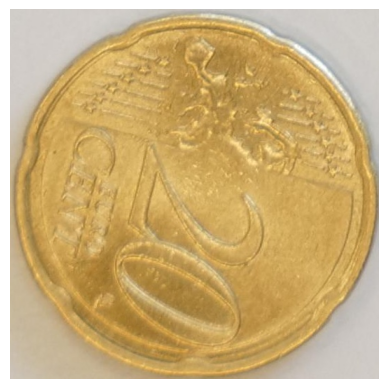

In [23]:
# Load all the image in output folder
images_json = []

# Load json
if os.path.exists(COINS_ANNOTATIONS_FILE):
    with open(COINS_ANNOTATIONS_FILE, "r") as f:
        images_json = json.load(f)

# for filename in sorted(os.listdir(path)):
for idx, x in enumerate(images_json):
    filename = x["filename"]
    value = x["value"]
    print(filename)
    print(POSSIBLE_VALUES[int(value)])
    img = cv2.imread(f"{COINS_IMAGES_FOLDER}/{filename}", cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    result = input("Good value ? (y/n/q) :")
    if result == "q":
        break
    if result == "n":
        clear_output(wait=True)
        for i in range(len(POSSIBLE_VALUES)):
            print(f"{i}: {POSSIBLE_VALUES[i]}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        result = input("Value of coin :")
        if result == "q":
            break
        if result == "":
            break
        if int(result) < 0 or int(result) >= len(POSSIBLE_VALUES):
            print("invalid value")
            break
        else:
            images_json[idx] = {"filename": filename, "value": result, "changed" : True}
    clear_output(wait=True)

with open(COINS_ANNOTATIONS_FILE, "w") as f:
    json.dump(images_json, f, indent=4)

# Classification and Feature extration with ResNet and a custom classification layer

We are using a pre-trained [EfficientNet model](https://arxiv.org/pdf/1905.11946), which extracts features using MBConv layers and squeeze-and-excitation optimization. Where MBConv are optimized convolution networks with residual connections and squeeze-and-excitation optimization looks for relevent features to keep. 


Since we are using a version that was trained on IMAGENET-1K, the classification layer is not suitable for our task. The original classification layer was designed to classify 1000 different classes; however, we only have 16 classes in our dataset.

The motivation for using a pre-trained model is that our dataset is too small to train a model from scratch to capture all the required details about a coin. It is easier to use a model that was trained to distinguish between objects in general and then fine-tune it for coin detection.

We will be using Pytorch as our machine learning framework. The first step is to create a usable dataset for Pytorch's DataLoaders. When loading the dataset, it is important to resize the images to the right dimensions (384x384) and normalize the images with the values it was used during pre-training (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). We also add transforms such as random rotation, color jitter and random erasing to improve the performance on the validation set by fighting overfitting on the training set. 

In [ ]:
class CoinDataset(Dataset):
    def __init__(self, features_path : str, data_json, transform : bool = False) -> None:
        super().__init__()
        self.raw_data = []
        for x in data_json:
            filename = x["filename"]
            img_path = f"{features_path}/{filename}"
            img = Image.open(img_path)
            self.raw_data.append({"image_features": img, "label": int(x["value"])})
        
        if transform:
            # https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s
            self.transform = v2.Compose([
                v2.Resize(400),
                v2.RandomCrop(384),
                v2.RandomRotation(degrees=(0, 360)),
                v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4, hue=0.3),
                v2.ToTensor(),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                v2.RandomErasing(p=0.2)
                ])
        else:
            self.transform = v2.Compose([
                v2.Resize(384),
                v2.CenterCrop(384),
                v2.ToTensor(),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self) -> int:
        n_data = len(self.raw_data)
        return n_data
    
    def __getitem__(self, index : int):
        features = None
        label = None

        features = self.raw_data[index]["image_features"]
        label = torch.tensor(self.raw_data[index]["label"])
    
        features = self.transform(features)
        return features, label


We only apply the transforms on the testing dataset. The train loader will use a batch_size of 16 which helps stabilize the training. We also shuffle so that the learning is not biased by the order of the images.

In [ ]:
# Load all the img from output folder and make a dataset
data_json = None
with open(COINS_ANNOTATIONS_FILE, 'r') as f:
    data_json = json.load(f)
train_data, test_data = train_test_split(data_json, test_size=0.2, random_state=42)
train_dataset = CoinDataset(COINS_IMAGES_FOLDER, train_data, transform=True)
test_dataset = CoinDataset(COINS_IMAGES_FOLDER, test_data, transform=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/home/bluedrack/.conda/envs/iapr/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


We then load the efficient_net_v2_s model with pre-trained weights from IMAGENET1K. Dropout was added to the custom classfication layer to reduce overfitting.

In [ ]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 16),
        )

    def forward(self, x):
        x = self.model(x)
        return x
model = EfficientNetModel()

The model is trained with an Adam optimizer with a learning rate of $1e-4$ and we are using a scheduler to reduce the learning rate if the validation loss is not going down during 10 consecutive epochs. Cross entropy loss is used which is standard for multiple class classification tasks. The model is trained for 35 epoch. This also may take some time, we also provided a pretrained model in case.

In [ ]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=10):
    model.to(device)
    steps = 0
    best_epoch = 0
    for epoch in range(epochs):
        model.train()
        for i, (data, target) in enumerate(train_loader):
        
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            acc = accuracy_score(target.cpu(), output.argmax(dim=1, keepdim=True).cpu())
            writer.add_scalar("Acc/train", acc, steps)
            writer.add_scalar("Loss/train", loss, steps)
            steps+=1
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Acc: {:.3f}'.format(
                    epoch, i * len(data), len(train_loader.dataset),
                    100. * i / len(train_loader), loss.item(), acc*100))
        running_vloss = []
        val_f1micro = []
        val_f1macro = []
        correct = 0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss.append(vloss.cpu())
                voutputs = voutputs.cpu()
                vlabels = vlabels.cpu()
                pred = voutputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(vlabels.view_as(pred)).sum().item()
                val_f1micro.append(f1_score(pred, vlabels, average='micro'))
                val_f1macro.append(f1_score(pred, vlabels, average='macro'))

        avg_vloss = np.mean(running_vloss)
        avg_vf1micro = np.mean(val_f1micro)
        avg_vf1macro = np.mean(val_f1macro)

        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('Val Epoch: {}\tLoss: {:.6f}, Acc: {:.3f}, F1 micro: {:.3f}'.format(
            epoch, avg_vloss, val_accuracy, avg_vf1micro
        ))

        writer.add_scalar("Loss/val", avg_vloss, (epoch + 1))
        writer.add_scalar("Acc/val", val_accuracy, (epoch + 1))
        writer.add_scalar("F1_micro/val", avg_vf1micro, epoch + 1)
        writer.add_scalar("F1_macro/val", avg_vf1macro, epoch + 1)
        scheduler.step(avg_vloss)
        if best_epoch < val_accuracy:
            best_epoch = val_accuracy
            torch.save(model.state_dict(), CLASSIFIER_MODEL_PATH)
                
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Log in Tensorboard
writer = SummaryWriter('runs/efficient_s_net_baseline_35_epochs')

train(model, train_loader, val_loader, optimizer, scheduler, nn.CrossEntropyLoss(), epochs=35)
writer.flush()
writer.close()

# Save the model
torch.save(model.stateVdict(), CLASSIFIER_MODEL_PATH)

Testing that the size of the model is in the requirement for the project.

In [ ]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

Loading the dlib train model for detecting all the bounding box of the coins in the images

In [ ]:
detector = dlib.simple_object_detector(COINS_DETECTOR_MODEL_PATH)

In [24]:
valid_extensions = ('.jpg')
model = EfficientNetModel()
model.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH))
model.eval()

transform = CoinDataset([], [], transform=False).transform

file_list = os.listdir(TEST_FOLDER)
image_files = [f for f in file_list if f.lower().endswith(valid_extensions)]

final_count = []

image_files = sorted(image_files)

for image_file in tqdm(image_files):
    answer = {}
    coins = []
    image_path = os.path.join(TEST_FOLDER, image_file)
    image = cv2.imread(image_path)
    image_name = image_file.removesuffix(".JPG")
    if image is None:
        print(f"Failed to load {image_file}")
        continue
    
    detected_im = detector(image)
    pathes = []
    coins = []
    image = Image.open(image_path)
    for i, detect_test in enumerate(detected_im):
        img_rgb = image
        d_box = detect_test
        coins.append(image.crop((d_box.left(), d_box.top(), d_box.right(), d_box.bottom())))
    answer["id"] = image_name
    for i in range(16):
        answer[POSSIBLE_VALUES[i]] = 0

    for c in coins:
        with torch.no_grad():
            coin_input = transform(c).unsqueeze(0).to(device)
            output = model(coin_input)
            res = output.argmax()
            answer[POSSIBLE_VALUES[res.item()]] += 1
    final_count.append(answer)

print("Creating csv file...")

df = pd.DataFrame(final_count)
df.to_csv(RESULT_FILE, index=False)

/home/bluedrack/.conda/envs/iapr/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 162/162 [07:26<00:00,  2.75s/it]

Creating csv file...


# Performances analysis

First of all, we tried to use simple morphology and treshold methods to detect the position of the corners, but we soon realized that this posed a huge problem in view of the disparity of images with or without the hand or with a noisy background. We struggled to get conclusive results. That's why we turned to dlib and its object detection method, and even though it requires a lot of annotation work, the results are more than satisfactory.

We then moved on to the classification of the pieces thus extracted. We tested a number of different things, firstly with ResNet of different sizes, but the results were not as good as with an EfficientNet, and we didn't see any significant difference between the M or S version of the EfficientNet. We also tried several layers of classification with BatchNorm, but again no improvement. Work was also carried out on the transformation that train images undergo to avoid overfit and artificially increase the number of images. We have a rather aggressive transformation, but the model manages to converge and we notice that the training set and the evaluation set have equivalent accurracy scores.

We put a non-exosive list in the test we made in the ./runs folder, which you can access with tensorboard with the command :

`tensorboard --logdir runs`


# Submit

The prediction for the test images can be found in the file `results/test-predictions.csv`